# Steam Data Exploration

*This forms part of a larger series of posts for my [blog](http://nik-davis.github.io) on downloading, processing and analysing data from the steam store. [See all posts here](http://nik-davis.github.io/tag/steam).*

<!-- PELICAN_BEGIN_SUMMARY -->

Now that we successfully downloaded and cleaned a whole dataset from Steam and Steamspy. We're going to be diving into that dataset, getting to grips with it, and trying to get a sense of the gaming industry as a whole. We'll try to focus on questions like 'What makes a game great?' and 'What do the most popular games look like?'. Our answers will relate specifically to the Steam environment, but hopefully we'll be able to uncover some interesting insights that we can relate to the wider video game industry.


<!-- PELICAN_END_SUMMARY -->

We'll start by importing the libraries we'll be using, then load and inspect the data.

In [1]:
# standard library imports
import itertools
import re

# third-party imports
import seaborn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# customisations
pd.set_option("max_columns", 100)
plt.style.use('default')
plt.rcdefaults()
# sns.set() # default seaborn style

## Import and Preprocess Data

For reference, here is a look at the structure of the cleaned data:

In [2]:
pd.read_csv('./data/steam_clean.csv').head()

,appid,name,release_date,english,french,german,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,economic_success
0,10,Counter-Strike,2000-11-01,1,1,1,Valve,Valve,windows;mac;linux,0,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,0,144225,3752,10480,149,2000000-5000000,10.5,36750000.0
1,20,Team Fortress Classic,1999-04-01,1,1,1,Valve,Valve,windows;mac;linux,0,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,0,3805,711,1342,24,2000000-5000000,5.0,17500000.0
2,30,Day of Defeat,2003-05-01,1,1,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3906,467,1501,29,5000000-10000000,5.0,37500000.0
3,40,Deathmatch Classic,2001-06-01,1,1,1,Valve,Valve,windows;mac;linux,0,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Classic,0,1469,317,2669,15,100000-200000,5.0,750000.0
4,50,Half-Life: Opposing Force,1999-11-01,1,1,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Classic,0,6520,358,2180,181,1000000-2000000,5.0,7500000.0


We removed all of the errors that we uncovered as part of the cleaning process, and have fairly neatly formatted data to work with. There are some preprocessing steps we need to take care of before the data is in a fully useful state to us, so let's outline those objectives here:

- Focus on games that are either in english, french or german and which run on windows
- Convert owners into a usable integer format by keeping the lower bound
  - Alternatively, could keep the upper bound or mid-point
- Come up with a rating score from positive and negative ratings (We'll be using [SteamDB](https://steamdb.info/blog/steamdb-rating/)'s method)
- Create a separate release_year column, to easily group by year
- Encode categories and genres into separate, binary columns, similar to the [one-hot encoding](https://pbpython.com/categorical-encoding.html) process

Other possibilities (which we won't be performing here):
- Estimate revenue from owners and price
- Create categories for price, such as: cheap, moderate, expensive

Below we define a function, `pre_process`, to handle this task, as well as four helper functions, and run it on the data.

In [3]:
def remove_non_language(df):
    # keep only rows marked as supporting english
    df = df[df['english'] ==1 ].copy()
    #df = df[(df['english'])>= 1].copy()
    # keep rows which don't contain 3 or more non-ascii characters in succession
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]
    
    # remove english column, now redundant
    df = df.drop(['english', 'french','german'], axis=1)
    
    return df


def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews
    
    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100


def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))


def process_cat_gen_tag(df):
    """Process categories, genres and steamspy_tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['categories'])
    
    # only going to use these categories (can uncomment to use others)
    cat_cols = [
        # 'Local Multi-Player',
        # 'MMO',
        # 'Mods',
        'Multi-player',
        # 'Online Co-op',
        # 'Online Multi-Player',
        'Single-player'
    ]
    
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # repeat for genre column names (get_unique used to find unique genre names, 
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genres'])
    
    # only keeping 'main' genres similar to steam store
    gen_cols = [
        # 'Accounting',
        'Action',
        'Adventure',
        # 'Animation & Modeling',
        # 'Audio Production',
        'Casual',
        # 'Design & Illustration',
        # 'Documentary',
        # 'Early Access',
        # 'Education',
        # 'Free to Play',
        # 'Game Development',
        # 'Gore',
        'Indie',
        'Massively Multiplayer',
        # 'Nudity',
        # 'Photo Editing',
        'RPG',
        'Racing',
        # 'Sexual Content',
        'Simulation',
        # 'Software Training',
        'Sports',
        'Strategy'
        # 'Tutorial',
        # 'Utilities',
        # 'Video Production',
        # 'Violent',
        # 'Web Publishing'
    ]
    
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        # alternate method using np.where:
        # df[col_name] = np.where(df['genres'].str.contains(col), 1, 0)
    
    # remove "non-games" based on genre
    # if a row has all zeros in the new genre columns, it most likely isn't a game, so remove (mostly software)
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
        
    # not using steamspy tags for now, as mostly overlap with genres
    # here's one way we could deal with them:
    # tag_cols = get_unique(df['steamspy_tags'])
    # df['top_tag'] = df['steamspy_tags'].apply(lambda x: x.split(';')[0])
    
    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    
    return df


def pre_process():
    """Preprocess Steam dataset for exploratory analysis."""
    df = pd.read_csv('./data/steam_clean.csv')
    print(len(df))
    # keep english only
    df = remove_non_language(df)
    print(len(df))
    # keep windows only, and remove platforms column
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    print(len(df))
    # keep lower bound of owners column, as integer
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
    print(len(df))
    
    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)
    
    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    
    # process genres, categories and steamspy_tag columns
    df = process_cat_gen_tag(df)
    
    
    return df

data = pre_process()
print(len(data))

print('Verify no missing values:')
print(data.isnull().sum().value_counts())

data.head()

30352
29160
29155
29155
28882
Verify no missing values:
0    30
1     1
dtype: int64


,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,10,Counter-Strike,2000-11-01,Valve,Valve,0,Action,0,144225,3752,10480,149,2000000,10.5,36750000.0,147977,0.974645,96.111053,2000,1,0,1,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,0,Action,0,3805,711,1342,24,2000000,5.0,17500000.0,4516,0.842560,80.911325,1999,1,0,1,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,Valve,Valve,0,Action,0,3906,467,1501,29,5000000,5.0,37500000.0,4373,0.893208,85.740618,2003,1,0,1,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,0,Action,0,1469,317,2669,15,100000,5.0,750000.0,1786,0.822508,77.934424,2001,1,0,1,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,0,Action,0,6520,358,2180,181,1000000,5.0,7500000.0,6878,0.947950,91.479528,1999,1,1,1,0,0,0,0,0,0,0,0,0


## Data Overview

Now preprocessing is complete we can begin to get a better idea of the structure of the data. With so many columns we'll pick a few to focus in on for now: genres, owners, price, year and ratings.

Using seaborn, we can easily view and compare kernel density estimation (KDE) and scatter plots describing the data, observing any patterns and potential relationships in the data. We'll apply a logarithmic transformation to the owners and total_ratings columns so we can compare them on a more reasonable scale.

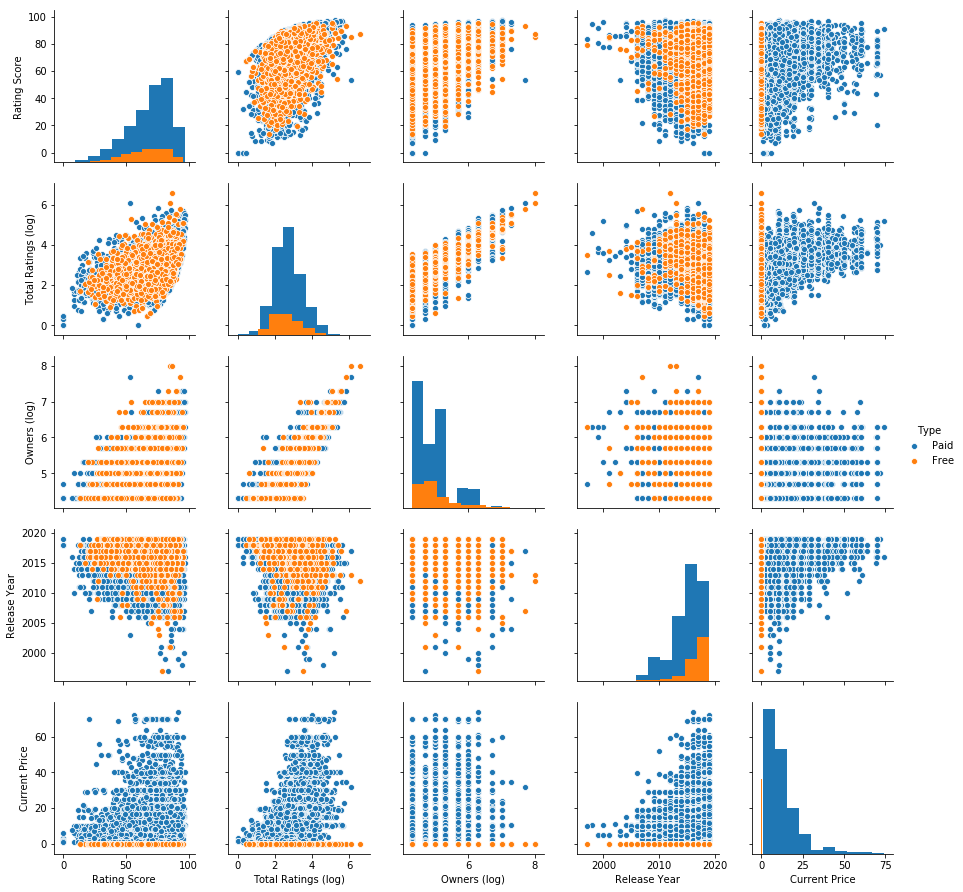

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Create a column to split free vs paid games
data['type'] = 'Free'

data.loc[data['price'] > 0, 'type'] = 'Paid'
data.loc[data['type'] == 'Free', 'price'] = 0
data[data['type'] == 'Free'].head()

# ensure no 0s in columns we're applying log to
df = data[(data['total_ratings'] > 0) & (data['owners'] > 0)].copy()
#print(len(df))

eda_df = pd.DataFrame(zip(df['rating'],
                          np.log10(df['total_ratings']),
                          np.log10(df['owners']),
                          df['release_year'],
                          df['price'],
                          df['type']
                         ),
                      columns=['Rating Score', 'Total Ratings (log)', 'Owners (log)', 'Release Year', 'Current Price' ,'Type'])

sns.pairplot(eda_df, hue='Type', diag_kind='hist')
plt.show()


From this visualisation, we can make some initial observations:
- Paid games look to have higher ratings on average than free games
- Ratings for free games are spread out across a slightly wider range

- It looks like there may be more owners for paid than free games, but it's unclear
- Slightly more ratings are given to paid games than free ones

- The more owners of a game, the more ratings it has
- Ratings for games with more owners look to be higher on average, or at the very least spread across a smaller and higher range. 

- Looking at the release year, it looks like there has been a shift towards more free games released in recent years
- More recent games are more expensive, but note that all prices are current prices, not prices at release

- A large proportion of games are priced between £0 and £20, with the majority being between £0 and £10

Whilst we can't draw any conclusions about the relationships at this stage, we can speculate about a few trends that we may wish to investigate throughout this project:
- Ratings appear to decrease over time, especially for free games, suggesting newer games may be worse overall, or rather, receive worse ratings
- As price increases, rating increases, so it's possible people are more likely to rate a game highly if they have spent more money on purchasing it. Also, it looks like the more expensive the game, the more ratings it has, which may mean that the more people pay for a game the more likely they are to leave a review
- The paid game are realeased with some interval between them. A supposition we can make here would be to say that game studio are working on a development schedule that seems to be synchronized.
- The more owners a game has, the higher the average rating appears to be, suggesting the better rated a game, the more people buy it

We can investigate some of these trends in time, but first we have to decide something about the dataset going forwards. It turns out a great many of the games in the dataset have between 0 and 20,000 owners (the lowest bound), and we have to decide whether to keep them or exclude them in our analysis. The conclusions we draw may be significantly impacted by this decision, as you will see.

Below we'll take a look at box plots comparing the ratings of games with 20,000 owners or more to the entire dataset. Each of these are further subdivided into paid games and free games.

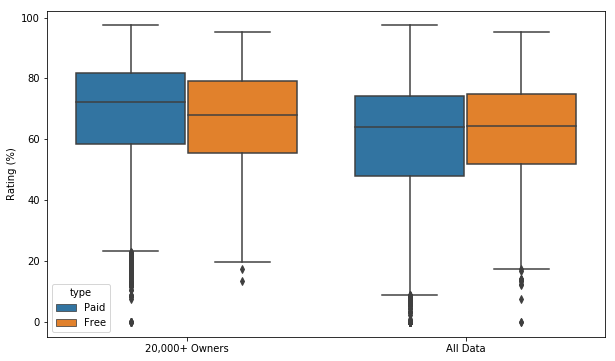

In [5]:
fig = plt.figure(figsize=(10,6))

dfa = data[data.owners >= 20000].copy()
dfa['subset'] = '20,000+ Owners'

dfb = data.copy()
dfb['subset'] = 'All Data'

ax = sns.boxplot(x='subset', y='rating', hue='type', data=pd.concat([dfa, dfb]))

ax.set(xlabel='', ylabel='Rating (%)')
plt.show()

There are two important things to notice here. First, the average ratings for paid games are significantly lower when taking all the data into account, compared to just looking at the games with 20,000 or more owners. Second, the average ratings for paid games are actually lower than the average ratings for free games when looking at all the data, whereas for games with 20,000 or more owners the ratings are noticably higher for paid games. Say we wanted to answer the question 'Which are better: Paid or Free games?', the answer would be completely different depending on the subset of the data we used. Clearly these games are having a large impact on average ratings for some reason.

One part of the explanation is down to the score calculation we used. As explained on the [Steam Database website](https://steamdb.info/blog/steamdb-rating/), ratings are biased towards 50%. Games with fewer total ratings are biased more heavily and games with more total ratings feel less of an impact from that bias. The main takeaway here is that games below 20,000 owners are more likely to have fewer ratings, and hence more likely to be pulled closer to 50%. As the majority of the ratings are above 50% this translates to a general lowering of scores. This is a side-effect of an attempt to make the scores fairer, more accurately reflecting what a better game looks like: If we simply looked at the ratio of positive ratings to total ratings, a game with 900 positive out of 1000 total ratings would receive the same score as a game with 9 out of 10 total ratings, yet statistically speaking the former is more significant and more certain because the sample size is much larger. The bias in the calculation we used reflects that.

Put simply, the calculation we used pulls games with few total ratings towards 50% more strongly than games with many total ratings.

This accounts for one part of the problem, and for the other part we'll take a look at how many games in the dataset have fewer than 20,000 owners:

In [6]:
print(f'Games with fewer than 20,000 owners: {data[data.owners < 20000].shape[0]}\n',
      f'Games with more than 20,000 owners: {data[data.owners >= 20000].shape[0]}')

Games with fewer than 20,000 owners: 19989
 Games with more than 20,000 owners: 8893


We can see that over 17,000 games in the dataset have fewer than 20,000 owners. That's over two thirds of the data, and these games will have a huge impact on any analysis we make, so including them or not is a very important decision.

There is no right answer here, but moving forward we have to keep the consequences in mind. It would be a good idea to consider the objectives of the analysis here, as that would help inform the decision. If we really wanted to identify niches in the gaming community, for example, then zooming in on these games with fewer owners may be really crucial. As we're more interested on getting a wider overview of what 'good' games look like, including them isn't so necessary.

Before we make a decision, we'll take a look at one more visualisation, which helps put things into perspective nicely.

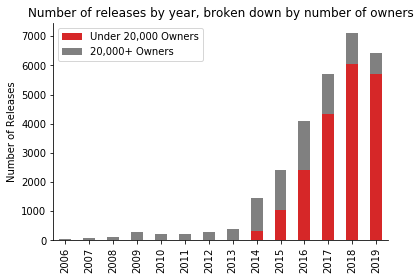

In [7]:
df = data.copy()

years = []
lt_20k = []
gt_20k = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2019:
        # very few releases in data prior to 2006, and we are at the begining of 2020.
        # so ignore these years
        continue
    
    # subset dataframe by year
    year_df = df[df.release_year == year]
    
    # calculate total with less than 20,000 owners, and total with 20,000 or more
    total_lt_20k = year_df[year_df.owners < 20000].shape[0]
    total_gt_20k = year_df[year_df.owners >= 20000].shape[0]
    
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
    
owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                         columns=['year', 'Under 20,000 Owners', '20,000+ Owners'])

ax = owners_df.plot(x='year', y=[1, 2], kind='bar', stacked=True, color=['tab:red', 'gray'])

ax.set_xlabel('')
ax.set_ylabel('Number of Releases')
ax.set_title('Number of releases by year, broken down by number of owners')
sns.despine()
plt.show()

The chart above shows the total number of releases by year in the dataset, and breaks these totals down by those games with less than 20,000 owners (in red), and those with 20,000 owners or more. Bear in mind that games with over 20,000 owners includes games with owners into the millions, so it's a very broad range.

By looking at this chart we can clearly see that, since 2014:
- The number of releases for games having 20,000 or more owners has remained relatively constant, seen by the sizes of the gray bars, at around 1,000 to 2,000 releases per year
- The number of releases with fewer than 20,000 owners has skyrocketed in this same period, seen by the sizes of the red bars, from maybe 250 in 2014 to nearly 7,000 in 2018

Of course games released more recently won't have had the same amount of time to generate sales as games released a long time ago, but I don't think this accounts for the pattern we see here. A couple of likely reasons may be that [Steam Greenlight opened in August 2012](https://store.steampowered.com/news/8761/), and following the closure of Greenlight, [Steam Direct opened in June 2017](https://steamcommunity.com/games/593110/announcements/detail/1328973169870947116). Both of these platforms allowed increasingly easier access for releasing games onto the Steam Store, allowing smaller independent titles to be listed, causing an explosion of releases that would otherwise have had to rely on other stores. Another reason is the [growth in the gaming industry](https://en.wikipedia.org/wiki/Video_game_industry#Economics), especially in mobile games which tend to be smaller, lighter games which are sometimes ported onto computers and the Steam Store.

My interpretation therefore is that the Steam store has been somewhat flooded with smaller releases and, in some cases, lower-quality releases - with games added to the Steam platform to try and tap into that market rather than being specifically developed for it - suggesting the vast majority can be set aside. We may lose some insight if we choose to remove these games, but I think we'll be able to gain more valuable information by focusing only on releases with 20,000 owners or more.

## Release Year

Something we noticed in the initial exploration was that the average rating appeared to be decreasing year on year. We've also just seen that - even discounting releases with fewer than 20,000 owners - the number of releases has generally been increasing over time. Let's now take a closer look and inspect this trend.

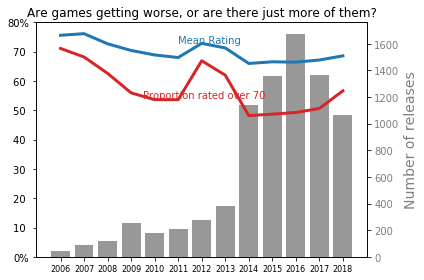

In [8]:
# Keeping games with only 20,000 owners or more
df = data[data.owners >= 20000].copy()

rating_threshold = 70

years = []
proportions = []
totals = []
avg_ratings = []
max_ratings = []

# calculate values for plotting
for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        continue
    
    year_data = df[df['release_year'] == year]
    total = year_data.shape[0]
    n_high_rating = year_data[year_data['rating'] >= rating_threshold].shape[0]
    avg_rating = year_data['rating'].mean() / 100
    
    years.append(year)
    totals.append(total)
    proportions.append(n_high_rating/total)
    avg_ratings.append(avg_rating)
    
    # print(f'{year} | {n_high_rating/total:.2f}')
    
fig, ax1 = plt.subplots()

# ensure lines drawn over bars
ax1.set_zorder(1)
ax1.patch.set_visible(False)

# plot trendlines
ax1.plot(avg_ratings, color='tab:blue', label='Average Rating', linewidth=3)
ax1.plot(proportions, color='tab:red', label=f'Proportion of games rated over {rating_threshold}', linewidth=3)

x_pos = np.arange(len(years))
ax1.set_xticks(x_pos)
ax1.set_xticklabels(years, fontsize=8)
ax1.set_yticks(np.arange(0, 0.9, 0.1))
ax1.set_yticklabels(['0%', '10 ', '20 ', '30 ', '40 ', '50 ', '60 ', '70 ', '80%'])

# instead of legend, place text directly over lines
ax1.text(5, 0.73, 'Mean Rating', color='tab:blue')
ax1.text(3.5, 0.54, 'Proportion rated over '+str(rating_threshold), color='tab:red')
# ax1.legend(loc='center', bbox_to_anchor=(0.5, 1.1))

# allow multiple axis on same plot
ax2 = ax1.twinx()

# plot number of releases by year
color = 'tab:gray'
ax2.bar(x_pos, totals, color=color, alpha=.8)

ax2.set_ylabel('Number of releases', color=color, fontsize=14)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Are games getting worse, or are there just more of them?')

fig.tight_layout()
plt.show()

The above plot shows the number of releases in each year as grey bars with the axis on the right. The blue line shows the average (mean) rating for games released in each year, with the rating as a percentage on the left axis. The red line shows what proportion of games released in each year are rated with a score over 75, and shows this proportion as a percentage on the left axis. As an example, in 2007 about 100 games were released, and the mean rating of these games is 75%. Of these games, 60% of them have a rating score of 75 or higher. That's a good year for games!

With this data, we can begin to answer the question: Are games getting worse, or are there just more of them?

We can see that the mean rating fell from about 75% in 2006 to just under 70% in 2018. With the exception of 2012, the mean rating is generally lower from any given year to the next.
 
There is a noticable peak across 2012 and 2013. Over half the games released in these years scored 75 or higher, and the mean rating was higher than the trend for those years.

There was a big surge in the number of releases, trebling from 2013 to 2014. At first it appears this drags down the average score, but if we ignore the 2012/2013 peak, the trend looks reasonably consistent.

So we can say for certain that the average rating has been decreasing over time, but how can we decide if the increasing number of releases has anything to do with that? We could start by looking at the correlation between these variables, using the Pearson correlation coefficient, which measures the strength and direction of a linear relationship:

In [9]:
import scipy.stats as stats
r, p_value = stats.pearsonr(totals, avg_ratings)

# using rating_ratio - pretty similar result
# stats.pearsonr(totals, df.groupby('release_year').mean().rating_ratio.loc[2006:2018].values)

print(f'Correlation coefficient (r): {r}\np-value: {p_value}')

Correlation coefficient (r): -0.7796031973036832
p-value: 0.0016760107095411618


The r value of -0.8 indicates a moderately strong negative correlation. This implies what we expected - in general as the number of releases increases, the mean rating decreases, and vice versa. Of course we can't then say that the increasing number of releases is *causing* this effect, but by this or some other reason, they are related. This would certainly be an interesting topic to gather more data on and explore further.

## Top Games, Ratings and Genres
 
So now we're a bit more familiar with the dataset, let's zoom in for a second on some really specific cases. Let's look at the top ten games, by rating, and see if anything sticks out. Then we'll move on to dissecting this, seeing if we can isolate some elements that are common to highly rated games.

,name,developer,publisher,release_year,genres,average_playtime,owners,rating,price
23,Portal 2,Valve,Valve,2011,Action;Adventure,843,10000000,97.399500,10.50
2820,The Witcher® 3: Wild Hunt,CD PROJEKT RED,CD PROJEKT RED,2015,RPG,3127,5000000,96.908220,39.99
7265,Factorio,Wube Software LTD.,Wube Software LTD.,2016,Casual;Indie;Simulation;Strategy;Early Access,4862,2000000,96.895131,30.00
1025,Terraria,Re-Logic,Re-Logic,2011,Action;Adventure;Indie;RPG,7730,10000000,96.616270,10.00
2890,RimWorld,Ludeon Studios,Ludeon Studios,2018,Indie;Simulation;Strategy,6660,1000000,96.386823,34.50
1834,The Binding of Isaac: Rebirth,"Nicalis, Inc.","Nicalis, Inc.",2014,Action,7107,2000000,96.347544,15.00
17,Portal,Valve,Valve,2007,Action,424,5000000,96.310672,10.50
6869,Stardew Valley,ConcernedApe,ConcernedApe,2016,Indie;RPG;Simulation,3141,5000000,96.295347,15.00
0,Counter-Strike,Valve,Valve,2000,Action,10480,2000000,96.111053,10.50
1476,Euro Truck Simulator 2,SCS Software,SCS Software,2012,Indie;Simulation,5141,5000000,96.065797,19.99


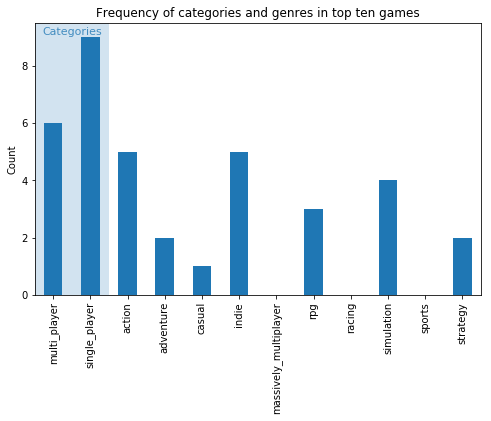

In [10]:
display_cols = ['name', 'developer', 'publisher', 'release_year', 'genres', 'average_playtime', 'owners', 'rating', 'price']
top_ten = df.sort_values(by='rating', ascending=False).head(10)
display(top_ten[display_cols])

# storing category and genre columns in a variable, as we'll be accessing them often
cat_gen_cols = df.columns[-13:-1]
ax = top_ten[cat_gen_cols].sum().plot.bar(figsize=(8,5))

ax.fill_between([-.5, 1.5], 10, alpha=.2)
ax.text(0.5, 9.1, 'Categories', fontsize=11, color='tab:blue', alpha=.8, horizontalalignment='center')

ax.set_ylim([0, 9.5])
ax.set_ylabel('Count')
ax.set_title('Frequency of categories and genres in top ten games')

plt.show()

Probably the most noticeable thing here is that 4 of these games are developed and published by Valve. In case you're not aware, Valve are the company behind Steam, which was primarily created as a digital content distribution service for their games.

Aside from this, we see that all of these games have at least 1 million owners, and there looks to be reasonable mix of older and newer titles.

From looking at the make up of the category and genre columns, it's apparent that almost all of them are single player games, and over half are action. None of the games are massively-multiplayer, racing or sports. We can't determine too much from this small sample, but we'll keep these observations in mind for later.

The question we may now want to ask ourselves is, are there genres that tend to be rated more highly than others?

We'll carry on looking at games with 20,000 or more owners, and from now on we'll also focus on paid games only. It's likely that there are plenty of interesting comparisons to be made between paid and free games, and this would make an interesting topic for another time.

First let's take a look at how ratings are distributed across the data.

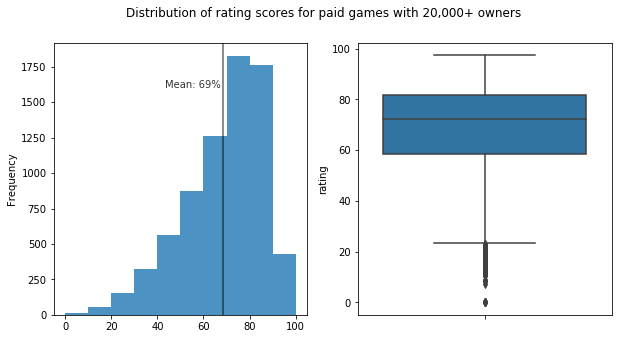

Mean rating: 68.68%


In [11]:
# paid with over 20,000 owners
df = data[(data.owners >= 20000) & (data.price > 0)].copy()

fig, axarr = plt.subplots(1, 2, figsize=(10,5))

df.rating.plot.hist(range=(0, 100), bins=10, ax=axarr[0], alpha=.8)
# sns.distplot(df.rating, bins=range(0,100,10), ax=axarr[0])

# plot line for mean on histogram
mean = df.rating.mean()
axarr[0].axvline(mean, color='black', alpha=.6)
axarr[0].text(mean-1, 1600, f'Mean: {mean:.0f}%', color='black', ha='right', alpha=.8)


ax = sns.boxplot(x='rating', data=df, orient='v', ax=axarr[1])
fig.suptitle('Distribution of rating scores for paid games with 20,000+ owners')
plt.show()

print(f'Mean rating: {df.rating.mean():.2f}%')

The ratings are left-skewed and about half of the ratings are between 60% and 80%. This means that games tend to receive more positive ratings than negative ratings.

We want to look at how the genre may affect ratings, and a good place to start is with a statistical test. By performing an analysis of variance (ANOVA) test, we can determine whether variation in rating is affected by variation in genre. We define a null hypothesis: Games grouped by genre have the same population mean - i.e. variations in genre have no effect on the mean. To reject or accept the null hypothesis we calculate an f statistic and compare it to a probability value.

In [12]:
gen_cols = cat_gen_cols.drop(['multi_player', 'single_player'])

f = stats.f_oneway(*(df.loc[df[g] == 1, 'rating'].values for g in gen_cols))
f

F_onewayResult(statistic=7.953829032106216, pvalue=7.89395412565523e-12)

The very small p-value means we can reject the null hypothesis, concluding that rating variance is affected by genre variance. This could mean, for example, that action games are rated higher than adventure games, on average. 

We can visually compare the rating distributions by genre using a violin plot, which is like a box plot but the width denotes a density estimation: the thicker the plot at any point, the more data there is at that point.

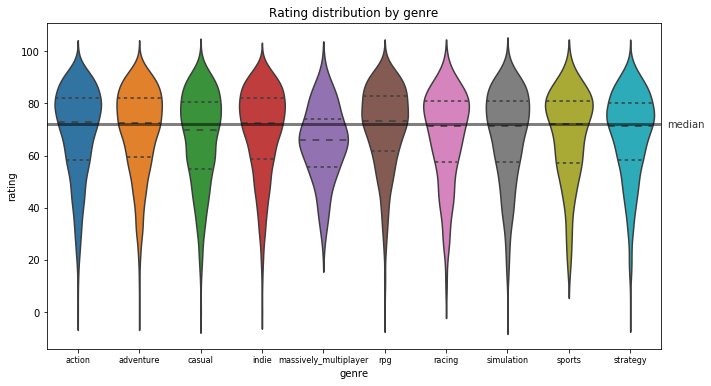

In [13]:
g_df = pd.DataFrame()

# create new dataframe with rating and genre, as games can belong to multiple genres
for col in gen_cols:
    ratings = pd.DataFrame(df.loc[df[col] == 1, 'rating'].values, columns=['rating'])
    ratings['genre'] = col
    g_df = pd.concat([g_df, ratings], axis=0)

fig, ax = plt.subplots(figsize=(11,6))
sns.violinplot(x='genre', y='rating', data=g_df, inner='quartile', ax=ax)
ax.axhline(g_df.rating.median(), color='black', lw=3, alpha=.5)
ax.text(9.6, g_df.rating.median()-1, 'median', color='black', alpha=.8)

ax.tick_params(axis='x', labelsize=8)
ax.set_title("Rating distribution by genre");
plt.show()

Because of the overlap (games can and usually belong to multiple genres), the differences to rating based on genre look quite minor for the most part - action and adventure games have very similar distributions, for example. There are a few of observations we can pick out clearly: 
- MMO (Massively Multiplayer) games tend to have much lower ratings than any other genre.
- Casual games have lower ratings than most, and racing and simulation games have slightly lower ratings than most
- RPG games have slightly better ratings than most

This chart doesn't take into account how many games there are in each genre, or rather the popularity of those genres in terms of how many games are created in each genre. We'll refer to this as the *creation popularity*. Similar to the chart we created for the top ten games, let's look at how many games are of each genre type. We'll also include two of the category columns: single-player and multi-player.

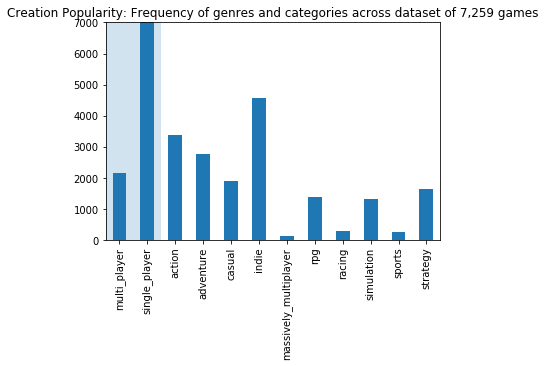

In [14]:
ax = df[cat_gen_cols].sum().plot.bar()

ax.fill_between([-.5, 1.5], 7000, alpha=.2)
ax.set_ylim([0, 6999])
ax.set_title(f'Creation Popularity: Frequency of genres and categories across dataset of {df.shape[0]:,} games')

plt.show()

We noticed before that MMO games had the lowest ratings on average. They are also the least frequent in the dataset, which could be because they are very expensive to make, expensive to maintain (server costs), and require constant content updates to keep players returning. For these reasons they are notoriously difficult to make, which seems to be reflected in their ratings. They also tend to be subscription-based (or more commonly in recent years, free-to-play with premium subscriptions available), adding to the expectations when constant payment is required. One final note here is that we probably removed a large number of them when we removed games with a price of 0, as many MMOs require no initial purchase, depending on the financial model.

There are also very few racing and sports games. The most popular genres are indie, action and adventure, in that order. It makes sense that there are many indie titles, as there are likely more smaller development studios than large ones, and they generally require much lower costs and less development time compared to big, triple-A releases.

Almost every game supports single-player, with about a fifth being or including multi-player. Games frequently contain elements of both, such as a single-player campaign against scripted AI and multi-player matchmaking over the internet. How this has changed over time, and the changing popularity of single versus multi-player games, is a huge topic that could easily make its own study.

Let's look at the popularity of games in another way - in terms of owners. We'll look at the average owners per game in each genre - we'll refer to this as *consumer popularity* - and compare it to the creation popularity we just looked at: the proportion of games in each genre.

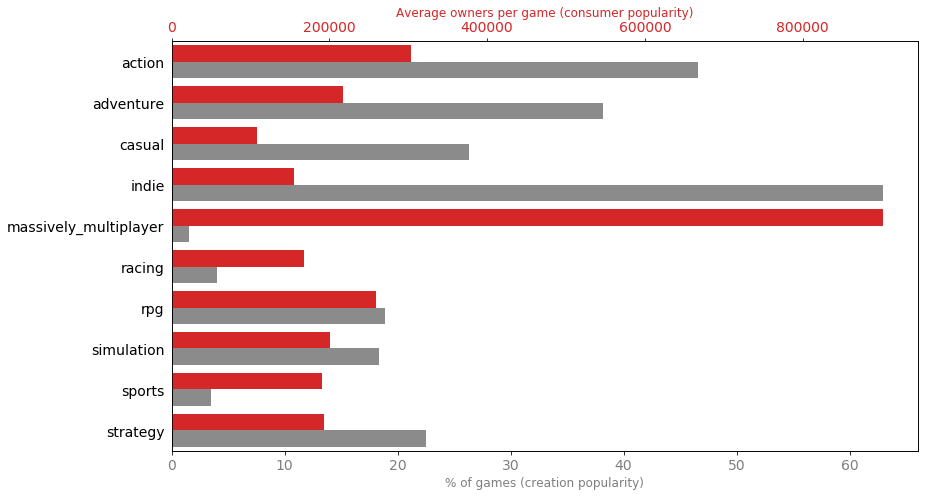

In [15]:
def plot_owners_comparison(df):
    # percentage of games in each genre
    total_owners_per_genre = df[gen_cols].multiply(df['owners'], axis='index').sum()
    average_owners_per_genre = total_owners_per_genre / df[gen_cols].sum()

    fig, ax1 = plt.subplots(figsize=(13,7))

    color = 'tab:gray'
    (df[gen_cols].mean() * 100).sort_index(ascending=False).plot.barh(ax=ax1, color=color, alpha=.9, position=1, fontsize=14, width=0.4)
    # ax1.set_ylabel('genre')

    ax1.set_xlabel('% of games (creation popularity)', color=color, size=12)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.tick_params(axis='y', left='off', top='off')
    # ax1.axes.get_yaxis().set_visible(False)

    ax2 = ax1.twiny()

    color = 'tab:red'
    average_owners_per_genre.sort_index(ascending=False).plot.barh(ax=ax2, color=color, alpha=1, position=0, fontsize=14, width=0.4)
    ax2.set_xlabel('Average owners per game (consumer popularity)', color=color, size=12)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.set_ylim([-.5, 9.5])

    plt.tight_layout()
    plt.show()
    
plot_owners_comparison(df)

Before we begin interpreting this chart, it's worth noting that there is only one game with more than 10,000,000 owners in this set of data, which could be heavily skewing those genres. It may be worth omitting this row and creating the chart again:

In [39]:
df[df.owners > 10000000]

,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,type
10,240,Counter-Strike: Source,2004-11-01,Valve,Valve,0,Action,147,93356,4011,6007,584,20000000,10.50,3.675000e+08,97367,0.958805,94.370324,2004,1,0,1,0,0,0,0,0,0,0,0,0,Paid
21,550,Left 4 Dead 2,2009-11-16,Valve,Valve,0,Action,70,306386,9624,2026,467,20000000,10.50,3.675000e+08,316010,0.969545,95.883099,2009,1,1,1,0,0,0,0,0,0,0,0,0,Paid
2338,271590,Grand Theft Auto V,2015-04-13,Rockstar North,Rockstar Games,18,Action;Adventure,77,518775,158455,9168,4716,20000000,34.90,1.221500e+09,677230,0.766025,75.929528,2015,1,1,1,1,0,0,0,0,0,0,0,0,Paid
12381,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,PUBG Corporation,PUBG Corporation,0,Action;Adventure;Massively Multiplayer,37,676918,583554,21776,10300,50000000,31.99,2.399250e+09,1260472,0.537035,53.312216,2017,1,0,1,1,0,0,1,0,0,0,0,0,Paid


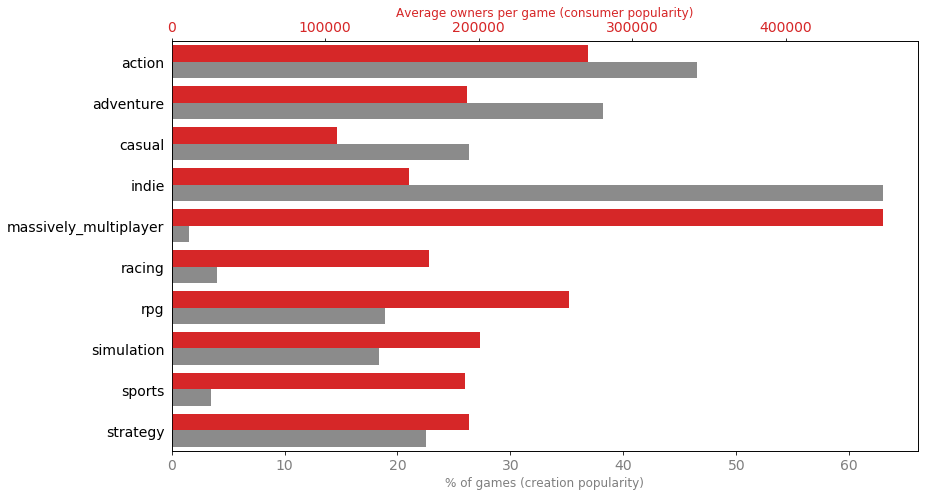

In [17]:
plot_owners_comparison(df[df.owners <= 10000000])

Any genre with a large red bar has a high number of average owners per game (a high consumer popularity), such as massively-multiplayer and action. We can think of these games as highly popular in the market, and potentially in high demand. There are likely to be many other factors in play, but a high number of average owners may mean that there are more people willing to buy games of that genre type. Games with a lower consumer popularity may be considered more niche, and have smaller potential audiences. The granularity may not be fine enough here to truly distinguish games in this way as most games comprise a mixture of genres to create a specific style.

Any genre with a large grey bar has a high proportion of games in the dataset (a high creation popularity), such as indie and action games. This means that large numbers of games are created in these genres, and may mean there is something inherently popular about these genres. As we touched on previously, indie games tend to have smaller teams and smaller budgets, meaning the barrier to entry for creating an indie game is lower and more teams (or even single people) can create them. Action games are popular, but then so many different games can include action in some manner, whether in the obvious action-movie-shooter way or in a less obvious, abstract kind of way. Action tends to refer to some form of combat or conflict mechanic, but can be interpreted in many other ways like high-energy or velocity.

Games with a high creation popularity and a low consumer popularity could indicate markets that are over-saturated, and new games would have a hard time generating high volumes of sale. There are so many games in the market that competing could be difficult, and it may be hard to stand out amongst the many options consumers face.

Conversely, and interestingly, games with a low creation popularity yet high consumer popularity may highlight markets that would readily accept new games in that genre. Across a smaller selection of games, the player-base is relatively high and may indicate the possibility for increased competition. Racing, RPG, simulation, sports and strategy games all look to fit this description.

It's important to remember that this is only within the Steam ecosystem. Before drawing conclusions it could be a good idea to look at other distribution platforms to see if these patterns hold, or if it is a result of the types of games that tend to appear on Steam. For example, video game company [Electronic Arts](https://www.ea.com) (EA) make a number of popular sports titles which aren't released on Steam and this could be having an unseen effect on the perceived popularity of this genre according to the data we have here. We have to keep in mind the limitations of the data, especially as the owners data comes with a wide margin of error.

## Owners, Pricing and Ratings

Moving on, let's take a look at some of the other relationships we observed in our initial EDA, specifically concerning the number of owners and ratings, and the price of a game and ratings.

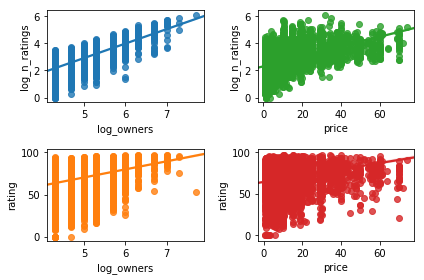

In [18]:
log_df = pd.DataFrame(zip(np.log10(df.owners), np.log10(df.total_ratings), df.rating, df.price),
                      columns=['log_owners', 'log_n_ratings', 'rating', 'price'])

fig, axarr = plt.subplots(2, 2)

sns.regplot(x='log_owners', y='log_n_ratings', data=log_df, ax=axarr[0][0])
sns.regplot(x='log_owners', y='rating', data=log_df, ax=axarr[1][0])
sns.regplot(x='price', y='log_n_ratings', data=log_df, ax=axarr[0][1])
sns.regplot(x='price', y='rating', data=log_df, ax=axarr[1][1])

plt.tight_layout()
plt.show()

We can make some interesting observations from these charts. All of these relationships have some form of positive correlation: as one variable increases, so does the other. If we first look at the two plots on the left, we can see that the more owners of a game, the more times that game is likely to have been rated, and generally the rating score will be higher. For the two plots on the right - comparing the price of a game to the number of ratings and the rating score - there are similar if less clear patterns. More expensive games tend to have more ratings and be rated more highly.

Let's first discuss the relationship between the number of owners of a game and its rating score. This is a pretty intuitive relationship, as better games are likely to become more popular and receive more positive ratings. Of course the size of the studio has a big role to play in marketing budget and exposure, meaning just because a game is highly rated doesn't mean it will become highly popular, but generally speaking highly popular games (with lots of owners) seem to very rarely have low ratings. There is one noticable exception here. A game with the highest number of owners and a very mediocre score of around 50, and it's one that has cropped up already:

In [19]:
df[df.owners == df.owners.max()][display_cols + ['positive_ratings', 'negative_ratings']]

,name,developer,publisher,release_year,genres,average_playtime,owners,rating,price,positive_ratings,negative_ratings
12381,PLAYERUNKNOWN'S BATTLEGROUNDS,PUBG Corporation,PUBG Corporation,2017,Action;Adventure;Massively Multiplayer,21776,50000000,53.312216,31.99,676918,583554


Interestingly, the number of people who rate a game appears roughly proportional to the number of owners of that game. This means that there is a rough number of reviews you can expect in relation to a certain number of sales, and games won't become popular without a proportional amount of feedback and interaction from the audience. What I mean here is that you won't get a game with a huge amount of owners that nobody leaves ratings for. You can expect the feedback and the community to grow with the size of the game in terms of sales.

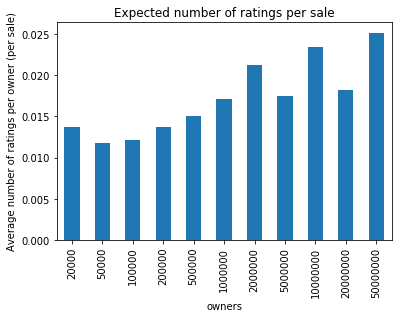

In [20]:
grp = df.groupby('owners')

ax = (grp['total_ratings'].mean() / sorted(df['owners'].unique())).plot.bar()
ax.set_ylabel('Average number of ratings per owner (per sale)')
ax.set_title('Expected number of ratings per sale');

As the owners data is an estimation, we can't be too exact with this relationship, however with the data we have we can get a rough prediction on how many ratings we can expect based on the number of owners, or, projecting this further, based on the number of expected sales. It looks like the more owners of a game, or the more sales it generates, the more likely people become to leave a review. Put another way, the bigger a game becomes, the bigger the proportion of the player base you can expect to leave a rating.

Relationships like this could help gauge the levels of support staff and customer service staff needed for a game, and estimate community interaction, for example. We could do this with other data as well, such as if our game relied on hosting servers, we could look at average playtime to inform the size of the servers we'd need. We could do with a bit more specific data here, but based on the size of the player-base and the expected playtime, we'd have an idea of the expected load on the servers. Long-term this could help determine how much hardware would be needed and the costs of maintaining the servers over the course of a game's lifetime.

For an even more specific example, gathering similar data specific to the launch window timeframe could be invaluable information when preparing for a good launch, as there seem to be a 
[number](https://www.news.com.au/technology/home-entertainment/sim-city-a-great-game-once-you-get-past-the-server-problems/news-story/9fa70029d13f88f2c26698972e61852a) 
[of](https://www.engadget.com/2012/05/17/blizzard-weighs-in-on-diablo-3-launch-issues/) 
[cases](http://www.tentonhammer.com/articles/remembering-the-launch-of-world-of-warcraft)
where games have launched with insufficient servers to accomodate players, potentially damaging the launch of a game,
[though that's not necessarily the problem when it comes to servers](https://www.gamesradar.com/uk/its-just-impossible-devs-explain-why-big-online-games-always-seem-to-break-at-launch/). 

There is also a positive correlation between the price of a game and its rating, and the price and the number of reviews it receives. The implications here are two-fold: first it could mean that the more expensive a game is, the more inclined a person may be to leave a review. Their money has value, so they want to balance the weight of that investment with feedback, be it positive, with praise, or negative, hopefully with constructive criticism about areas they didn't like, which could be improved upon in future.

The second implication is that the more someone pays for a game, the more likely they are to give it a positive rating. We don't want to read too deeply into this relationship, but it suggests that if someone pays more for a title they may be more inclined to view it positively, as otherwise it would be perceived as a waste of their money. I imagine this only holds true to a point, as if they become disappointed with a game or purchase, then the more expensive it was the more likely they might be to complain, acting as a form of compensation against their investment. 

It could simply be that more expensive games tend to reflect a higher budget and more development time, so usually a better quality game, but it is an interesting reflection nonetheless.

## Pricing

When looking at pricing, the biggest problem with this dataset is that it doesn't include the price of a game at release, but instead its current price. Especially for games that have been out a long time, the price may have been reduced repeatedly. Fortunately due to Steam's frequent sale model, games now tend to maintain higher base prices and regularly drop them during sale events. Still, let's look at recent releases only for the next section to minimise the effect of diminishing prices.

Here we're going to take a quick look at the breakdown of pricing strategy for games in each genre.

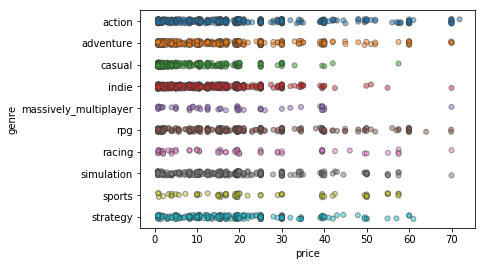

In [21]:
g_df = pd.DataFrame()

for col in gen_cols:
    temp_df = df[df[col] == 1].copy()
    temp_df['genre'] = col
    g_df = pd.concat([g_df, temp_df], axis=0)


recent_df = g_df[g_df['release_year'] >= 2018].copy()
ax = sns.stripplot(x='price', y='genre', data=recent_df, jitter=True, alpha=.5, linewidth=1);

The most noticable trend is that it seems very unlikely and very difficult to price a game over £15-£20. There also definitely appears to be a hard cap on pricing - almost all games are priced at £50 or less. This is definitely a big enough topic worthy of its own separate discussion, and we'd need more concrete data of release prices over time, but it highlights the tremendous value for money that is expected for games as compared to other forms of media. 

Let's say that you pay £30 for a game and play it for 50 hours. That works out at a cost of 60p per hour of play. Say you bought a movie or a CD for £10 with a hour and a half's content. That would work out at a cost of about £6.60 per hour of content. Of course you would likely listen to a CD repeteadly, and may rewatch a movie multiple times over the years, but the same could be said for the replayability of a game's content, depending on the game. The point being that in terms of unique content, games often have a much higher value-per-hour than other forms of media.

As I said this is a topic worthy of its own discussion and investigation, and these figures are completely hypothetical. Many other factors need to be considered such as the change from single purchases to subscription models for many forms of media, like music and TV, and the increase in prevalence of DLC and other revenue streams to boost the revenue for a game, offsetting the relatively low increase in game prices. Also there is huge variation in the amount of playtime a game offers, and it could be interesting to take a look at data from [howlongtobeat](howlongtobeat.com). Some games may have a modest 10-hour single-player campaign ([Portal 2](https://howlongtobeat.com/game.php?id=7231)) 
while others offer more open-ended exploration-based campaigns, with upwards of 100 hours of gameplay ([The Witcher 3](https://howlongtobeat.com/game.php?id=10270)).
More sandbox-oriented games can offer thousands of hours of playtime from a single purchase ([Kerbal Space Program](https://howlongtobeat.com/game.php?id=12079)).

## Developers and Publishers

There are a few ways we could take a look at developers and publishers, trying to get an idea of the influence they have, and isolating the 'best' ones. Whilst we could rank them by a metric, such as average rating, we run into a problem:

In [22]:
pv = df.pivot_table(index='developer', 
               values=['appid', 'rating'], 
               aggfunc={'appid':'count', 'rating':np.mean})

pv = pv.rename({'appid':'num_releases'}, axis=1).sort_values(by='rating', ascending=False)

pv.head()

,num_releases,rating
developer,,
Wube Software LTD.,1,96.895131
Re-Logic,1,96.616270
Ludeon Studios,1,96.386823
ConcernedApe,1,96.295347
Askiisoft,1,95.890150


The problem, as you can probably tell, is that the highest rated developers by average game rating have all made 1 game. It would be more useful if we could take into account a variety of parameters and turn them into a score, giving us the ability to prioritise certain values over others, like the amount of owners (as a proxy for total sales) or the total number of releases, depending on what we consider most important.

In [37]:
def get_scores(df):
    # extracting values
    num_releases = df.num_releases**(1/2)
    log_owners = np.log10(df.sum_owners)
    mean_rating = df.mean_rating
    log_ratings = np.log10(df.total_ratings)
    
    # calculating z scores
    z_num_releases = stats.zscore(num_releases)
    z_log_owners = stats.zscore(log_owners)
    z_mean_rating = stats.zscore(mean_rating)
    z_log_ratings = stats.zscore(log_ratings)

    # calculate score (per row)
    # half owners and number of ratings, because allude to the same thing
    # give smaller weight to number of releases
    # rating most important, give highest weighting
    scores = (.1*z_num_releases + .5*.2*z_log_owners + .5*z_mean_rating + .5*.25*z_log_ratings) / 3
        
    return scores
pv_df = df.copy()
pv_df['num_releases'] = 1
pv = pv_df.pivot_table(index='developer',
                       values=['num_releases', 'owners', 'rating', 'total_ratings', 'price'],
                       aggfunc={'num_releases': np.sum,
                                'owners': np.sum, 
                                'rating': np.mean,
                                'total_ratings': np.sum,
                                'price': np.mean}
                      ).rename({'owners': 'sum_owners', 
                                'price': 'mean_price',
                                'rating': 'mean_rating'}, axis=1)

pv['score'] = get_scores(pv)
pv = pv.sort_values(by='score', ascending=False)
pv.head(10)

7259


,num_releases,sum_owners,mean_price,mean_rating,total_ratings,score
developer,,,,,,
Valve,18,107800000,9.302778,87.607762,1044045,0.751063
id Software,16,10000000,10.610625,82.887456,150472,0.587664
Ubisoft Montreal,18,18820000,17.462222,75.534351,670775,0.580261
Quiet River,19,1450000,1.304737,85.367423,37662,0.564284
Bethesda Game Studios,9,22800000,31.106667,80.983894,615208,0.542842
Klei Entertainment,8,7250000,15.192500,86.803488,207167,0.537299
Daedalic Entertainment,19,4990000,21.989474,79.540274,37980,0.535121
"CAPCOM Co., Ltd.",10,15200000,30.664000,80.711994,284758,0.526103
Re-Logic,1,10000000,10.000000,96.616270,387681,0.517600


This scoring system isn't perfect, but it's a start. It takes some metrics for each developer, applies some mathematical transformations, and calculates a numerical score which, when ordered from greatest to least, gives us a ranking of the 'best' developers.

By filtering through the original data, we can add the names of the top games from each developer, in case we're interested.

In [24]:
def get_top_games(pv, col):
    pv = pv.copy()
    for pv_name in pv.index:
        top_games = df[df[col] == pv_name].sort_values(by='rating', ascending=False).name

        top_5 = [n for n in top_games[:5]]

        pv.loc[pv_name, 'top_games'] = ', '.join(top_5)
        
    return pv
    
pv_top_ten_devs = get_top_games(pv.head(10), 'developer')

with pd.option_context("display.max_colwidth", 1000):
    display(pv_top_ten_devs[['score', 'top_games']])

,score,top_games
developer,,
Valve,0.751063,"Portal 2, Portal, Counter-Strike, Left 4 Dead 2, Half-Life 2"
id Software,0.587664,"DOOM, QUAKE, Ultimate Doom, Quake III Arena, Wolfenstein 3D"
Ubisoft Montreal,0.580261,"Tom Clancy's Splinter Cell Chaos Theory®, Assassin’s Creed® IV Black Flag™, Tom Clancy's Rainbow Six® Siege, Far Cry 3 - Blood Dragon, Assassin’s Creed® Brotherhood"
Quiet River,0.564284,"Zup! X, Zup! 8, Zup! 2, Zup! S, Zup!"
Bethesda Game Studios,0.542842,"The Elder Scrolls V: Skyrim, The Elder Scrolls IV: Oblivion® Game of the Year Edition, The Elder Scrolls III: Morrowind® Game of the Year Edition, The Elder Scrolls V: Skyrim Special Edition, Fallout 3: Game of the Year Edition"
Klei Entertainment,0.537299,"Don't Starve Together, Oxygen Not Included, Mark of the Ninja: Remastered, Hot Lava, Invisible, Inc."
Daedalic Entertainment,0.535121,"Ken Follett's The Pillars of the Earth, Chaos on Deponia, Deponia, Edna & Harvey: Harvey's New Eyes, The Night of the Rabbit"
"CAPCOM Co., Ltd.",0.526103,"RESIDENT EVIL 2 / BIOHAZARD RE:2, RESIDENT EVIL 7 biohazard / BIOHAZARD 7 resident evil, Resident Evil / biohazard HD REMASTER, Devil May Cry® 4 Special Edition, Devil May Cry HD Collection"
Re-Logic,0.517600,Terraria


By wrapping the previous tasks in funcions, we can easily repeat the process for publishers:

In [25]:
pv = pv_df.pivot_table(index='publisher',
                       values=['num_releases', 'owners', 'rating', 'total_ratings', 'price'],
                       aggfunc={'num_releases': np.sum,
                                'owners': np.sum, 
                                'rating': np.mean,
                                'total_ratings': np.sum,
                                'price': np.mean}
                      ).rename({'owners': 'sum_owners', 
                                'price': 'mean_price',
                                'rating': 'mean_rating'}, axis=1)

pv['score'] = get_scores(pv)

pv_top_ten_pubs = get_top_games(pv.sort_values(by='score', ascending=False).head(10), col='publisher')

with pd.option_context("display.max_colwidth", 1000):
    display(pv_top_ten_pubs)

,num_releases,sum_owners,mean_price,mean_rating,total_ratings,score,top_games
publisher,,,,,,,
Ubisoft,94,50940000,23.469787,74.002472,1395204,0.700731,"South Park™: The Stick of Truth™, Valiant Hearts: The Great War™ / Soldats Inconnus : Mémoires de la Grande Guerre™, Child of Light, Rocksmith® 2014 Edition - Remastered, Dark Messiah of Might & Magic"
Devolver Digital,64,21530000,12.879844,81.538827,382406,0.659808,"Katana ZERO, Hotline Miami, Broforce, GRIS, My Friend Pedro"
Valve,21,123800000,8.926190,88.106792,1535409,0.650198,"Portal 2, Portal, Counter-Strike, Left 4 Dead 2, Half-Life 2"
Square Enix,85,33100000,18.225412,72.125195,412401,0.627332,"Supreme Commander: Forged Alliance, Deus Ex: Game of the Year Edition, FINAL FANTASY VII, DRAGON QUEST® XI: Echoes of an Elusive Age™ - Digital Edition of Light, Just Cause 2"
SEGA,60,28180000,20.832500,78.753422,313008,0.623033,"Yakuza Kiwami 2, Warhammer® 40,000: Dawn of War® - Dark Crusade, Warhammer® 40,000: Dawn of War® - Soulstorm, Warhammer® 40,000: Dawn of War® - Game of the Year Edition, Rome: Total War™ - Collection"
Bethesda Softworks,32,43050000,24.976250,78.658651,1084799,0.569920,"Dishonored, Fallout: New Vegas, The Elder Scrolls V: Skyrim, The Elder Scrolls IV: Oblivion® Game of the Year Edition, DOOM"
BANDAI NAMCO Entertainment,53,10890000,38.120566,75.486124,270534,0.546930,"PAC-MAN™ Championship Edition DX+, Tales of Berseria™, CODE VEIN, Saint Seiya: Soldiers' Soul, Katamari Damacy REROLL"
THQ Nordic,85,16810000,15.357294,67.391728,152466,0.544380,"Neighbours from Hell Compilation, Impossible Creatures Steam Edition, Titan Quest Anniversary Edition, The Book of Unwritten Tales, Gothic II: Gold Edition"
Sekai Project,33,2930000,14.363030,85.372855,81281,0.528233,"NEKOPARA Vol. 2, NEKOPARA Vol. 3, Rabi-Ribi, CLANNAD, NEKOPARA Vol. 1"


Now we have an idea of the top developers and publishers, let's investigate the games they tend to make. One way we could do this is by looking at the proportion of games they make in each genre. For each game from a publisher, every genre column has a 1 or a 0, so by looking at the average of each of these columns we can figure out what proportion of their games are in each genre.

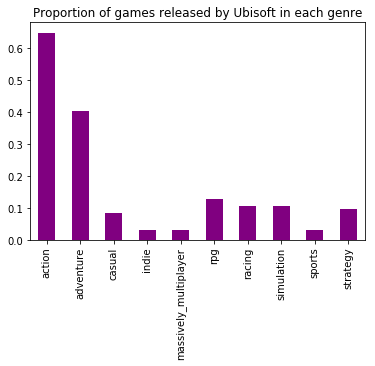

In [26]:
df[df.publisher == 'Ubisoft'][gen_cols].mean().plot.bar(color='purple')
plt.title('Proportion of games released by Ubisoft in each genre');

Just by looking at Ubisoft's games, we can see that a little over 60% of them are action, and just under 40% are adventure, with a scattering of games across the other genres. If we were to categorise the games they made I think it would be reasonable to say they make predominantly action or action-adventure games. 

If we wanted to make this process a little easier, instead of manually generating and reading a chart, we could look at the maximum value after computing the mean, giving us the 'most common' genre from that publisher. This way we could feed in the name of any known publisher (or developer), and return the genre of game they most commonly release.

In [27]:
for publisher in pv_top_ten_pubs.index:
    most_common_genre = df[df.publisher == publisher][gen_cols].mean().idxmax()
    print(f'{publisher} usually release {most_common_genre} games.')

Ubisoft usually release action games.
Devolver Digital usually release indie games.
Valve usually release action games.
Square Enix usually release action games.
SEGA usually release action games.
Bethesda Softworks usually release action games.
BANDAI NAMCO Entertainment usually release action games.
THQ Nordic usually release action games.
Sekai Project usually release indie games.
Paradox Interactive usually release strategy games.


This is a good start, but as we just saw, Ubisoft can be better described by looking at their top two genres, action and adventure. 

We could simply return the top two genres, but that may not be appropriate for all of the publishers. Some may mainly release one type of game, like Valve.

7259

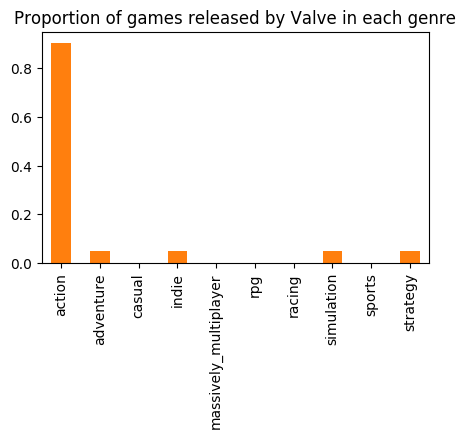

In [36]:
df[df.publisher == 'Valve'][gen_cols].mean().plot.bar(figsize=(5,3), color='tab:orange')
plt.title('Proportion of games released by Valve in each genre');

And others, like THQ Nordic, may be split across a large number of genres.

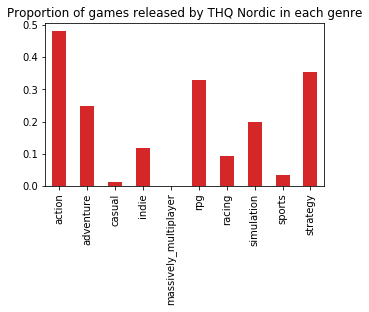

In [29]:
df[df.publisher == 'THQ Nordic'][gen_cols].mean().plot.bar(figsize=(5,3), color='tab:red')
plt.title('Proportion of games released by THQ Nordic in each genre');

Let's try and define a little more complex logic. We can calculate the proportions of the proportions, then use a while loop to total them up until a threshold is reached, say 0.5 for half. 

This way, if one genre dominates, we can return just that genre, whereas if there is a more varied mix, we can combine these to more accurately reflect the nature of the games released by a particular publisher.

In [30]:
for publisher in pv_top_ten_pubs.index:
    gen_values = df[df.publisher == publisher][gen_cols].mean().sort_values(ascending=False)
    
    total = gen_values.sum()
    proportions = [val / total for val in gen_values]
    
    gen_proportions = pd.DataFrame(zip(gen_values, proportions), index=gen_values.index, columns=['mean', 'proportion'])
    
    total_proportion = 0
    i = 0
    genres = []
    
    while total_proportion < .5:
        row_prop = gen_proportions.iloc[i, 1]
        genres.append(gen_proportions.index[i])
        total_proportion += row_prop
        i += 1
    
    print(f'{publisher} tend to release {"/".join(genres)} games.')

Ubisoft tend to release action/adventure games.
Devolver Digital tend to release indie/action games.
Valve tend to release action games.
Square Enix tend to release action/rpg games.
SEGA tend to release action/strategy games.
Bethesda Softworks tend to release action games.
BANDAI NAMCO Entertainment tend to release action/rpg games.
THQ Nordic tend to release action/strategy/rpg games.
Sekai Project tend to release indie/casual games.
Paradox Interactive tend to release strategy/rpg games.


In a way this is like a very simple machine learning model in that it takes some inputs and 'predicts' the types of games a publisher is likely to release based on what it has made so far. 

In the future, we may wish to experiment with applying some machine learning models to our dataset, so to wrap up this exploration phase we'll take a look at some correlations.

## Correlations

The function below plots a correlation heatmap from a dataframe and has been adapted from the [seaborn documentation](http://seaborn.pydata.org/examples/many_pairwise_correlations.html).

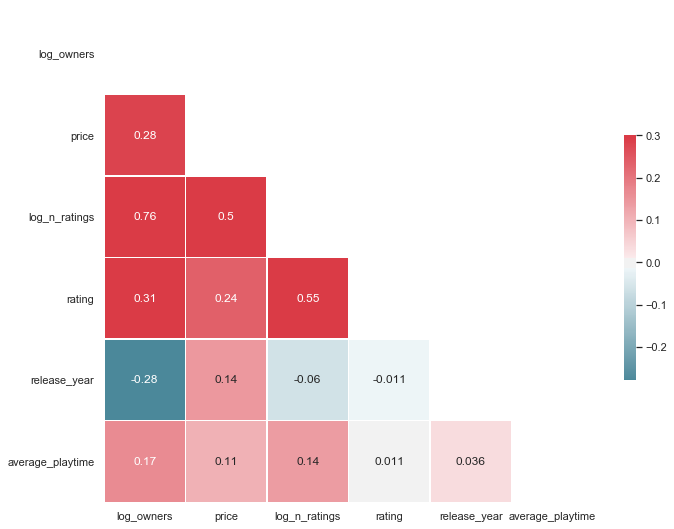

In [31]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style='white')
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    f, ax = plt.subplots(figsize=(11,9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    
    plt.yticks(rotation=0)
    plt.show()
    plt.rcdefaults()

corr_df = df.copy()
corr_df['log_owners'] = np.log10(corr_df['owners'])
corr_df['log_n_ratings'] = np.log10(corr_df['total_ratings'])

plot_correlation_heatmap(corr_df[['log_owners', 'price', 'log_n_ratings', 'rating', 'release_year', 'average_playtime']])

We noticed some of these trends already, including the relationship between the number of owners and the number of ratings, between price and number of ratings, and between the release year and the number of owners.

We'll now plot a similar heatmap just for the category and genre columns.

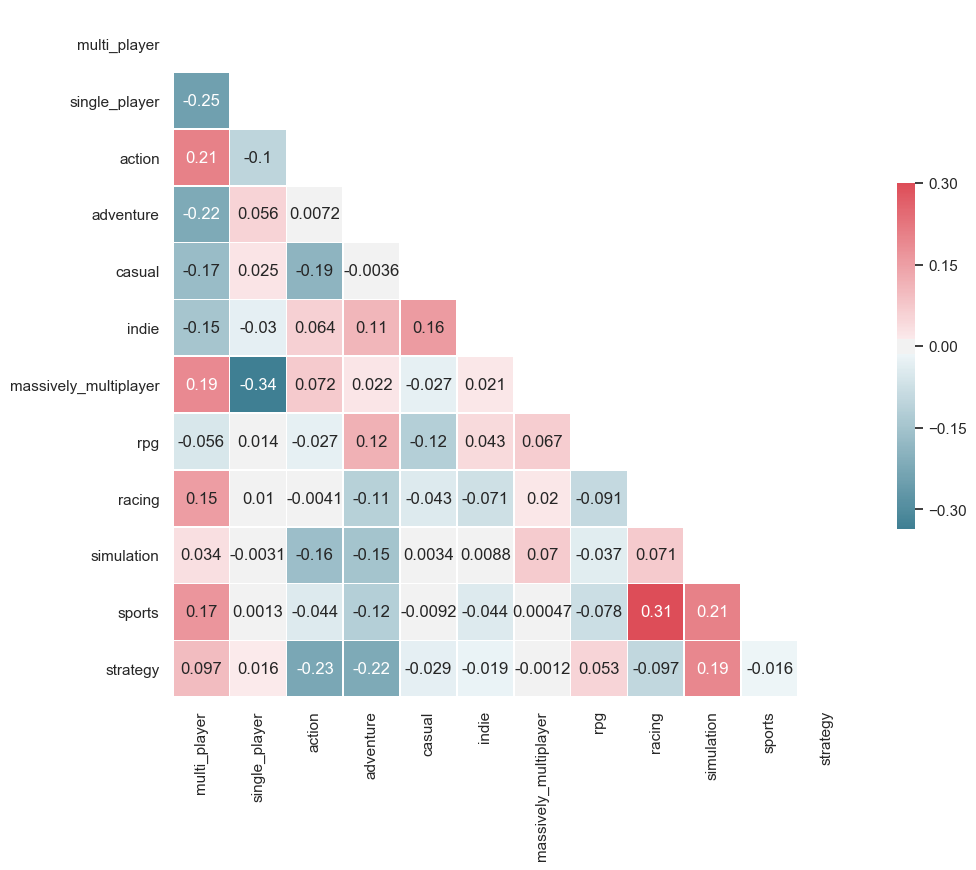

In [32]:
plot_correlation_heatmap(corr_df[cat_gen_cols])

It's interesting to look at which genres correlate with others, suggesting the genre types which do or do not mix. For example racing games are often sports games, and it's unusual for a single-player game to be massively-multiplayer, which is no surprise really. This could be a good starting point to provide the inspiration for a new and original genre experiment.

## Wrapping Up

Already this has been an incredibly long project, and I feel like we've only scratched the surface as far as exploring this dataset goes. Clearly we have many options for where to go next. First we'll review a summary of our main findings:

- The last five years has seen a huge increase in releases on Steam
- Average rating has been decreasing each year
- Massively-Multiplayer games tend to be the worst rated by far
- RPG games tend to be the best rated (but only slightly)
- Most games on the Steam store are Indie or Action
- Racing, RPG, Simulation, Sports and Strategy genres are mostly likely to have room for growth
- The more owners of a game, the more ratings it will receive, and the higher that rating is likely to be
- More expensive games tend to receive more ratings, and usually have higher ratings on average
- Most games are priced below £20, with a maximum of around £50-£60
- Valve games are generally well received and sell highly, so why no Half-Life 3?

Looking forward, here are some thoughts on where to go next:

- Look further into free games, and free vs paid games
- Investigate games on or not on different platforms (PC/Mac/Linux in this data, or could include consoles with additional data)
- Combine with other datasets to expand features and get more specific and accurate data ([this scrape](https://www.kaggle.com/gregorut/videogamesales) of video game sales may be useful, as well as [this dataset](https://www.kaggle.com/kasumil5x/howlongtobeat-games-completion-times) of howlongtobeat completion times)
- Look at machine learning models, especially the use of embeddings for categorical variables
- Expand on any of the topics explored in this post - there are plenty of avenues to explore!

In [33]:
# alternative score method using rank
rank_pv = pv.copy()
rank_pv['mean_rating'] = rank_pv['mean_rating'].round(decimals=0)

rank_cols = ['num_releases', 'sum_owners', 'mean_rating', 'total_ratings']

for col in rank_cols:
    rank_pv['rank_'+col] = rank_pv[col].rank(method='min', ascending=False)

rank_pv['avg_rank'] = 0

for col in rank_cols:
    rank_pv['avg_rank'] += rank_pv['rank_'+col]

rank_pv['avg_rank'] /= 4

rank_pv.sort_values(by='avg_rank').head(10)

,num_releases,sum_owners,mean_price,mean_rating,total_ratings,score,rank_num_releases,rank_sum_owners,rank_mean_rating,rank_total_ratings,avg_rank
publisher,,,,,,,,,,,
Valve,21,123800000,8.926190,88.0,1535409,0.650198,43.0,1.0,212.0,1.0,64.25
The Behemoth,3,7200000,16.500000,94.0,119087,0.470301,314.0,40.0,10.0,46.0,102.50
Coffee Stain Publishing,6,11100000,14.500000,88.0,119788,0.452071,166.0,21.0,212.0,45.0,111.00
Supergiant Games,4,3400000,18.872500,92.0,67131,0.440021,246.0,81.0,54.0,69.0,112.50
Square Enix;Feral Interactive (Mac);Feral Interactive (Linux),4,7700000,26.495000,89.0,212455,0.454205,246.0,39.0,161.0,29.0,118.75
Klei Entertainment,7,7150000,14.964286,86.0,205723,0.447140,140.0,41.0,348.0,30.0,139.75
Sekai Project,33,2930000,14.363030,85.0,81281,0.528233,21.0,99.0,412.0,61.0,148.25
TaleWorlds Entertainment,3,4000000,13.323333,89.0,109141,0.412386,314.0,71.0,161.0,49.0,148.75
Unknown Worlds Entertainment,3,3200000,17.263333,89.0,133304,0.406874,314.0,84.0,161.0,42.0,150.25


# Data for the Exploitation

Now that our data has been explored, we are going to take a look at the network's organisation of our data. For this, we will first save our dataframe to use it in the notebook responsible for the exploration of the data.

In [41]:
data.to_csv('./data/steam_ready.csv', index=False)

In [42]:
print(len(data))
data.head()

28882


,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,economic_success,total_ratings,rating_ratio,rating,release_year,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,type
0,10,Counter-Strike,2000-11-01,Valve,Valve,0,Action,0,144225,3752,10480,149,2000000,10.5,36750000.0,147977,0.974645,96.111053,2000,1,0,1,0,0,0,0,0,0,0,0,0,Paid
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,0,Action,0,3805,711,1342,24,2000000,5.0,17500000.0,4516,0.842560,80.911325,1999,1,0,1,0,0,0,0,0,0,0,0,0,Paid
2,30,Day of Defeat,2003-05-01,Valve,Valve,0,Action,0,3906,467,1501,29,5000000,5.0,37500000.0,4373,0.893208,85.740618,2003,1,0,1,0,0,0,0,0,0,0,0,0,Paid
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,0,Action,0,1469,317,2669,15,100000,5.0,750000.0,1786,0.822508,77.934424,2001,1,0,1,0,0,0,0,0,0,0,0,0,Paid
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,0,Action,0,6520,358,2180,181,1000000,5.0,7500000.0,6878,0.947950,91.479528,1999,1,1,1,0,0,0,0,0,0,0,0,0,Paid
